# YOLOv5 on the xView Dataset with Coupons v1.1

8 Dec 2021, Alex Denton, AE4824

## Before You Start 
YOLOv5 Tutorial: https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/ <br>
My GitHub Repo: https://github.com/awd86/yolov5

Notes on scripts and syntax:

- I recommend doing <i>all of the following</i> on the DGX because the dataset is very large. It takes nearly an hour to transfer (once coupon'd) via USB3.0 on the DGX machines.

- I did <i>not</i> use Jupyter Notebook for this task. I used PyCharm IDE to write my Python code and exectuted <i>train.py</i> from terminal. Some of the required packages are only available on Pip. You can probably use Conda and Jupyter Notebooks, but I haven't done testing. 

- "!" means that Jupyter (or a .py file) will run that command in a new terminal instance. The terminal instance will be created within your virtual environment, but each new "!" is a new terminal. If you need to run multiple commands in one instance, put them on 1 line with ";" separators.

- "python" vs. "python3" depends on your machine's aliasing. If you want to alias "python" to run "python3" instead of your machine's default python release, you can look up how to edit your profile. <i>Do this at your own risk!</i> I have set mine up this way and tend to write "python"...you can safely replace that with "python3" if you're having issues. 

### (needed before making venv and launching jupyter notebook)

Clone YOLOv5 GitHub repo and install requirements.txt in a Python>=3.6.0 environment, including PyTorch>=1.7. Models and datasets download automatically from the latest YOLOv5 release. I'm sucessfully using 3.8 and 3.9 on different machines.<br><br>



NOTE: PyTorch>=1.9 with new torch.distributed.run is recommended (replaces older torch.distributed.launch commands below). See https://pytorch.org/docs/stable/distributed.html for details.

You'll want to download my .py files into the cloned YOLOv5 Repo (to have to most current version of YOLOv5). Here are the ones you'll need:
- HowTo_YOLOv5_xView.ipynb (this document)
- coupons.py  (divides the picture and labels into coupons)
- split_set.py  (to divide images/labels into 'train' and 'val' sets)
- re_classify.py  (to change class names and remove 'None' class)
- vague_classes.py  (where new class names are specified
- autosplit_txt.py  (replicates the autosplit files created by the YOLO converted, described below)

The last piece to the puzzle is the file that converts xView labels into YOLO format. That can be found in the /data/ directory (folder) of the YOLOv5 clone'd repo. There is a file in there called 'xView.yaml' that specifies the data structure. At the bottom they've included the python code to convert your xView dataset (awesome of them!). You'll have to copy/paste to a new .py and modify the paths to fit your file structure. You're also going to end up modifying copies of this .yaml to specify the data structure for your runs.

## Check the local Cuda version

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_Oct_11_21:27:02_PDT_2021
Cuda compilation tools, release 11.4, V11.4.152
Build cuda_11.4.r11.4/compiler.30521435_0


## Check PyTorch version & GPU Compatability
- torch >= 1.9
- CudaDeviceProperties should have something under 'name' - this means it is compatible

In [2]:
import torch
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


torch 1.10.0+cu113 _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40536MB, multi_processor_count=108)


## Configure Multi-GPU DistributedDataParallel Mode
https://github.com/ultralytics/yolov5/issues/475

Before specifying GPUs, <a href="https://hsf-training.github.io/hsf-training-ml-gpu-webpage/02-whichgpu/index.html">determine the parameters</a>:




In [1]:
import torch
use_cuda = torch.cuda.is_available()

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 7605
__Number CUDA Devices: 4
__CUDA Device Name: Tesla V100-DGXS-32GB
__CUDA Device Total Memory [GB]: 34.063712256


Note: DGX1 and DGX4 both report "Number of CUDA Devices: 5" but the correct number to specify is "4"
<br>There are only 4 GPUs. This script might be counting the CPU as an additional CUDA device,<i> but train.py won't run</i> if you say "5"

You will have to pass python the following along with the usual arguments:

like this:

--nproc_per_node specifies how many GPUs you would like to use. In the example above, it is 4.<br>

--batch is the total batch-size. It will be divided evenly to each GPU. In the example above, it is 64/4=16 per GPU.<br>

The code above will use GPUs 0... (N-1).

Notes<br>
- Windows support is untested, Linux is recommended.
- '--batch' must be a multiple of the number of GPUs.
- GPU 0 will take slightly more memory than the other GPUs as it maintains EMA and is responsible for checkpointing etc.

If you get RuntimeError: Address already in use, it could be because you are running multiple trainings at a time. To fix this, simply use a different port number by adding --master_port like below,

## Download the xView Dataset:

https://challenge.xviewdataset.org/data-download  (requires site registration)

NOTE: The folder architecture is very important!!<br>
It doesn't have to be exactly like this, but it does need to be specified in data.yaml<br>

top level<br>
|<br>
|_ yolov5 (contains all py code and this file)<br>
|&emsp;|_ venv()<br>
|&emsp;|_ models<br>
|&emsp;&emsp;|_ xView.yaml. * model specification<br>
|<br>
|_ data_xView<br>
&emsp;   |_ data.yaml * class and image/label location specification<br>
&emsp;   |_ train<br>
&emsp;   | &emsp;|_ images()<br>
&emsp;   | &emsp;|_ labels()<br>
&emsp;   |<br>
&emsp;   |_ val<br>
&emsp;   | &emsp;|_ images()<br>
&emsp;   | &emsp;|_ labels()<br>
&emsp;   |<br>
&emsp;   |_ test<br>
&emsp;     &emsp; |_ images()<br>




Alternatively, make sure that the 'data.yaml' points to the correct directories. For instance:

train: ./data_xView/train/images <br>
val: ./data_xView/val/images <br>

Also make sure that the 'xView.yaml' model specification has: <br>

nc:[your number of categories] <br>
<br>

I highly recommend making different'xView.yaml' and 'data.yaml' files for each permutation.<br>
Also, I recommend making a new 'data_xView' or at least new 'labels' directories for each permutation.<br>


<hr border-top: 24px solid #bbb; border-radius: 10px>

#  * * * Prepare Dataset * * *

## Split 'train' dataset into 'train' and 'test'
The 'train' set is the only one with labels. The 'test' folder will be swapped with 'val' after couponing.

***Important Note*** the 'test' and 'val' folder name swap is done inefficiently in the follow code. It is written this way because of the order I built the program...I haven't rewritten it here. Fix the issue and tell everyone you wrote the whole code train ;)

In [ ]:
split_set('data_xView',0.2)  # 0.2 is the percent reserved for testing

## This is the code I used to 'coupon' the train, test, and val sets. 

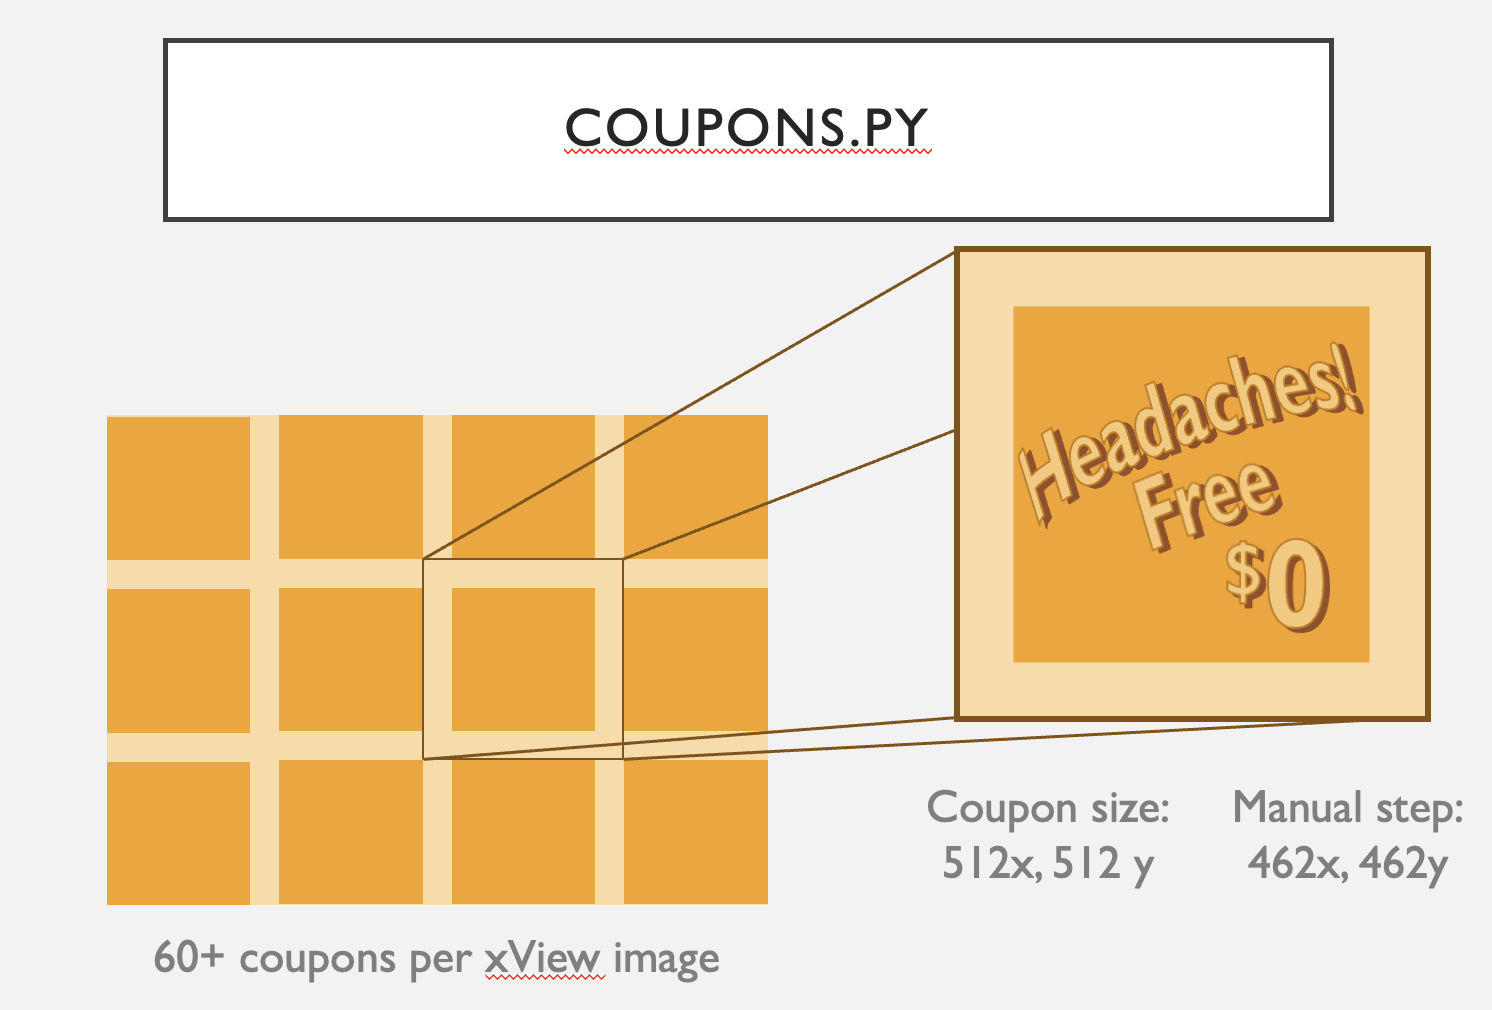

A coupon is different than a patch or a chip:

Patch: intended to be joined at the edge. Losses objects at the intersection<br>
Chip: scoped to target of interest, losses context

Coupon: overlaps with neighbors to preserve objects at the interections. Conatins context information and – potentially – multiple targets per coupon.

<i>Note 21 Aug 2022:</i> It turns out that this behavior can be replicated using the normal patch method with overlap. Whelp, never getting that dev time back. I haven't gone through the trouble of re-scripting for overlapping patches because I haven't returned to this code.


When this started, 'train' and 'test had images and labels but 'val' did not. Unfortunately for this particular setup, 'val' needs to have labels and 'test' isn't used. Therefore I swapped the names of the directories around. 

## Create dictionaries to augment the Classes with Elimination and Aggregation

'vague_classes.py' is modified manually within the file

In [2]:
!python3 vague_classes.py

Stripped contains 30 distinct classes
Goldilocks contains 29 sets aggregated into 3 classes
HHG contains 24 sets aggregated into 1 class


## Create modified label files

In [ ]:
goldilocks('data_xView/labels/train','data_xView/labels/train_01_stripped',convert_strip)
goldilocks('data_xView/labels/val','data_xView/labels/val_01_stripped',convert_strip)
goldilocks('data_xView/labels/train','data_xView/labels/train_02_gl',convert_gl)
goldilocks('data_xView/labels/val','data_xView/labels/val_02_gl',convert_gl)
goldilocks('data_xView/labels/train','data_xView/labels/train_03_hhg',convert_hhg)
goldilocks('data_xView/labels/val','data_xView/labels/val_03_hhg',convert_hhg)

***IMPORTANT NOTE*** You'll have to manually re-name the label folders that you want to use during runtime to <i>train</i> and <i>val</i>. This is what YOLO expects based on parallel structure to the image files specified in the data.yaml.

## Define model configuration and architecture (needed in runtime):

Check 'data.yaml' and 'xView.yaml' (model) files for each run:<br>
- data.yaml : structure of image data folders, number of classes, name of classes
- xView.yaml : repeat number of classes (must match), specifies architecture model in PyTorch format

## Make an account on WandB.ai to watch training progress and get auto-generated charts

https://wandb.ai/

<hr border-top: 24px solid #bbb; border-radius: 10px>

#  * * * Execution * * *

## Execute train.py

Train Custom YOLOv5 Detector!
Here, we are able to pass a number of arguments:<br>

img: define input image size (must be <b>multiple of 32</b>)<br>
  '--rect' allows non-square input images<br>
batch: determine batch size (multiple of number of GPUs)<br>
epochs: define the number of training epochs.<br>
data: <b>set the path to our data.yaml file</b><br>
cfg: <b>specify our model configuration xView.yaml</b><br>
weights: specify a path to pretrained weights if using transfer learning. (Note: some available from Ultralytics)<br>
name: <b>result names</b><br>
nosave: only saves the final checkpoint <b>(not recommended, will keep best model if this is left out)</b><br>
cache: cache images for faster training<br>

## Original Classes

***IMPORTANT NOTE*** Do <i>not</i> run these sequentially. You must change the name of your label folder. Otherwise you will simply retrain on the previous labels.

## Stripped Classes (1st elimination)

***IMPORTANT NOTE*** Do <i>not</i> run these sequentially. You must change the name of your label folder. Otherwise you will simply retrain on the previous labels.

## Goldilocks Classes (aggregated)

***IMPORTANT NOTE*** Do <i>not</i> run these sequentially. You must change the name of your label folder. Otherwise you will simply retrain on the previous labels.

## HolyHandGrenade Classes (singular aggregate class by 2nd elimination)